# 12 Complete Recognition System

In [1]:
# Import librerie
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms

# Scikit-learn per preprocessing e metriche
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Impostazioni
np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"Device: {device}")
print(f"CUDA disponibile: {torch.cuda.is_available()}")

import os, urllib.request

# GitHub Release URL for pretrained weights
WEIGHTS_BASE_URL = os.environ.get('WEIGHTS_URL', 'https://github.com/SamueleBolotta/CEAR/releases/download/v1.0/')
WEIGHTS_DIR = '../pretrained_weights'
os.makedirs(WEIGHTS_DIR, exist_ok=True)

def load_or_train(model, train_fn, weights_filename, device='cpu'):
    """Load pretrained weights if available, otherwise train and save.
    Also saves/loads training history as JSON alongside weights."""
    weights_path = os.path.join(WEIGHTS_DIR, weights_filename)
    history_path = weights_path.replace('.pt', '_history.json')

    def _load_history():
        if os.path.exists(history_path):
            import json as _json
            with open(history_path, 'r') as f:
                return _json.load(f)
        return None

    if os.path.exists(weights_path):
        model.load_state_dict(torch.load(weights_path, map_location=device, weights_only=True))
        print(f"Loaded pretrained weights from {weights_path}")
        return _load_history()
    elif WEIGHTS_BASE_URL:
        try:
            url = WEIGHTS_BASE_URL + weights_filename
            urllib.request.urlretrieve(url, weights_path)
            # Also try downloading history
            try:
                urllib.request.urlretrieve(
                    WEIGHTS_BASE_URL + weights_filename.replace('.pt', '_history.json'), history_path)
            except Exception:
                pass
            model.load_state_dict(torch.load(weights_path, map_location=device, weights_only=True))
            print(f"Downloaded and loaded weights from {url}")
            return _load_history()
        except Exception as e:
            print(f"Could not download weights: {e}. Training from scratch...")

    history = train_fn()
    torch.save(model.state_dict(), weights_path)
    print(f"Saved weights to {weights_path}")
    if history is not None:
        import json as _json
        with open(history_path, 'w') as f:
            _json.dump(history, f)
        print(f"Saved training history to {history_path}")
    return history

PyTorch version: 2.10.0+cu128
Torchvision version: 0.25.0+cu128
Device: cuda
CUDA disponibile: True


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 457kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.7MB/s]


Training set: (60000, 28, 28)
Test set: (10000, 28, 28)

Range valori pixel: [0, 255]
Classi: [0 1 2 3 4 5 6 7 8 9]


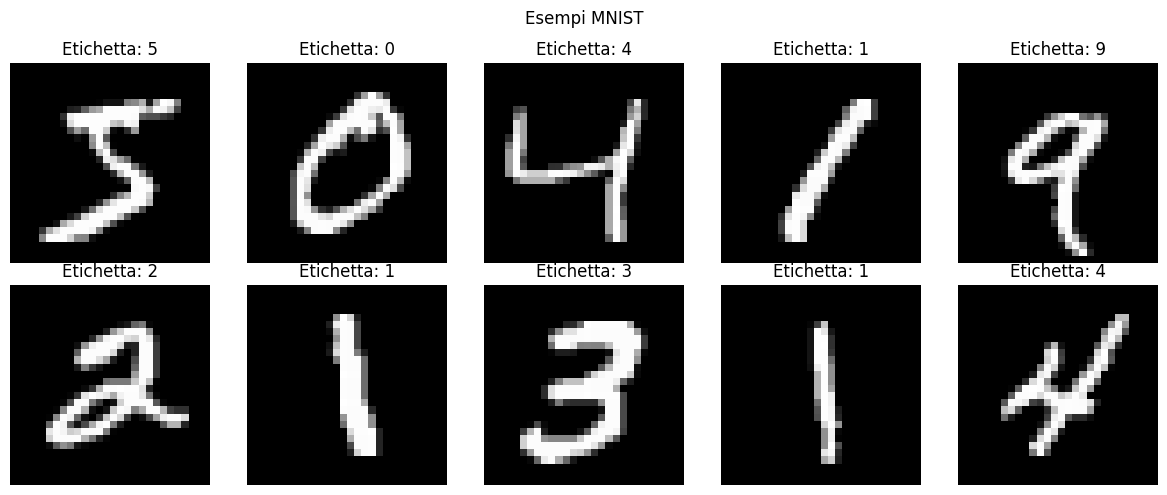

In [2]:
# Caricamento MNIST da torchvision
mnist_train = torchvision.datasets.MNIST(root='../data', train=True, download=True)
mnist_test = torchvision.datasets.MNIST(root='../data', train=False, download=True)

X_train = mnist_train.data.numpy()  # (60000, 28, 28)
y_train = mnist_train.targets.numpy()
X_test = mnist_test.data.numpy()
y_test = mnist_test.targets.numpy()

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nRange valori pixel: [{X_train.min()}, {X_train.max()}]")
print(f"Classi: {np.unique(y_train)}")

# Visualizzazione esempi
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i], cmap='gray')
    ax.set_title(f"Etichetta: {y_train[i]}")
    ax.axis('off')
plt.suptitle('Esempi MNIST')
plt.tight_layout()
plt.show()

In [3]:
# Flatten: da (28, 28) a (784,)
X_train_flat = X_train.reshape(-1, 28 * 28)
X_test_flat = X_test.reshape(-1, 28 * 28)

print(f"Shape dopo flatten:")
print(f"  Training: {X_train_flat.shape}")
print(f"  Test: {X_test_flat.shape}")

# Normalizzazione
X_train_norm = X_train_flat / 255.0
X_test_norm = X_test_flat / 255.0

print(f"\nRange dopo normalizzazione: [{X_train_norm.min():.2f}, {X_train_norm.max():.2f}]")

Shape dopo flatten:
  Training: (60000, 784)
  Test: (10000, 784)

Range dopo normalizzazione: [0.00, 1.00]


## 8. Esercitazione: Sistema di Riconoscimento Completo

Implementa un sistema completo di riconoscimento cifre.

TEST SISTEMA RICONOSCIMENTO CIFRE

Test Approccio Deep Learning:
Preprocessing 30000 immagini per deep_learning...
Training deep_learning...
Downloaded and loaded weights from https://github.com/SamueleBolotta/CEAR/releases/download/v1.0/nb04_sistema_dl.pt
Training completato


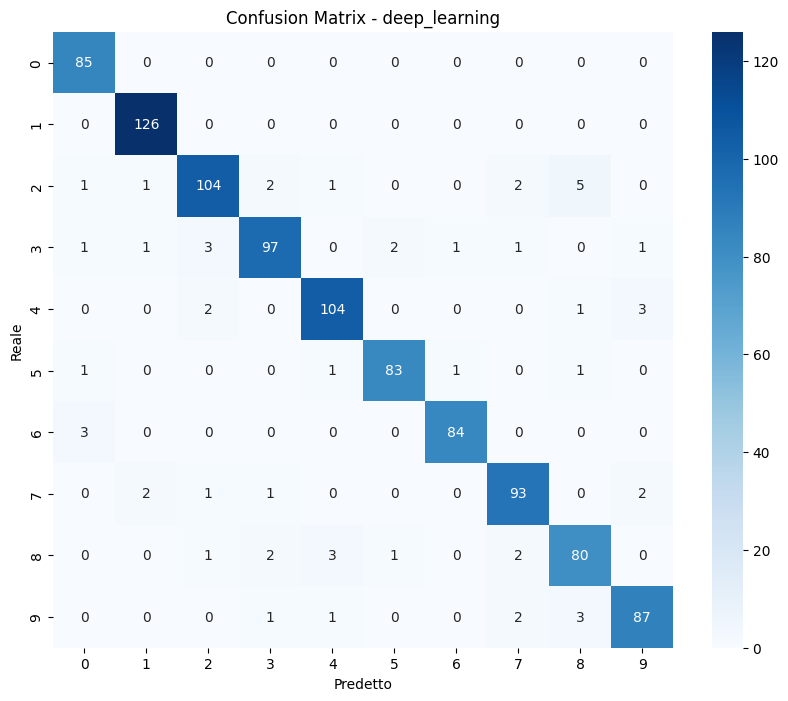


Accuracy: 0.9430

Test Approccio Classico:
Preprocessing 5000 immagini per classico...
Training classico...
Training completato


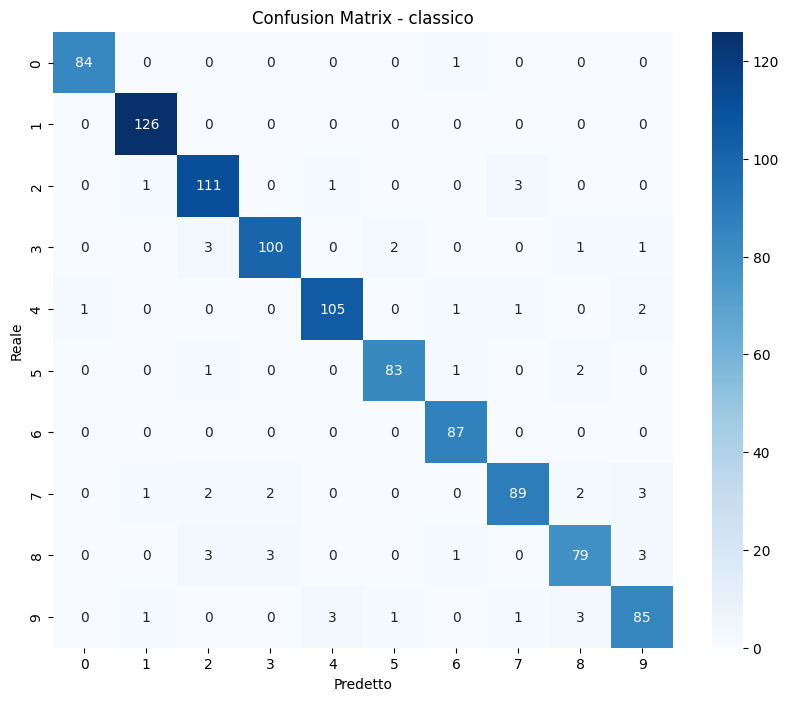


Accuracy: 0.9490

Visualizzazione Predizioni


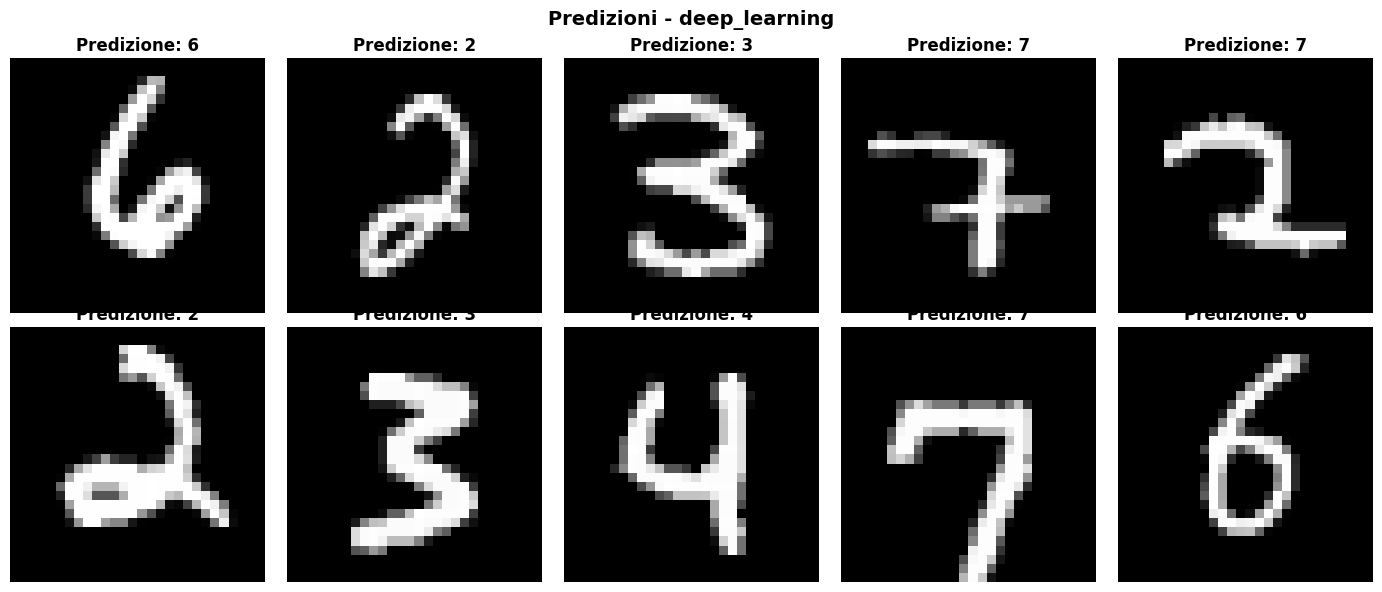

In [27]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import hog

class SistemaRiconoscimentoCifre:
    """
    Sistema completo per riconoscimento cifre.
    Supporta sia approccio classico che deep learning.
    """

    def __init__(self, approccio='deep_learning'):
        """
        Args:
            approccio: 'classico' o 'deep_learning'
        """
        self.approccio = approccio
        self.model = None
        self.scaler = None
        self.is_trained = False
        # Assumiamo che 'device' sia definito globalmente (es. torch.device('cuda' o 'cpu'))
        self.device = device if 'device' in globals() else torch.device('cpu')

    def preprocess_image(self, image):
        """
        Preprocessa un'immagine singola.

        Args:
            image: array numpy (28, 28)

        Returns:
            Immagine preprocessata
        """
        if self.approccio == 'classico':
            features = hog(
                image,
                orientations=9,
                pixels_per_cell=(8, 8),
                cells_per_block=(2, 2),
                visualize=False
            )
            return features
        else:
            img_normalized = image / 255.0
            return img_normalized.flatten()

    def build_model(self):
        """
        Costruisce il modello in base all'approccio.
        """
        if self.approccio == 'classico':
            self.model = SVC(kernel='rbf', C=10, gamma='scale')

        elif self.approccio == 'deep_learning':
            self.model = nn.Sequential(
                nn.Linear(784, 128),
                nn.BatchNorm1d(128),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(128, 64),
                nn.BatchNorm1d(64),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(64, 10)
            ).to(self.device)

    def train(self, X_train_imgs, y_train_labels, X_val=None, y_val=None, epochs=10):
        """
        Addestra il modello.
        """
        print(f'Preprocessing {len(X_train_imgs)} immagini per {self.approccio}...')
        X_train_processed = np.array([self.preprocess_image(img) for img in X_train_imgs])

        if self.model is None:
            self.build_model()

        print(f'Training {self.approccio}...')

        if self.approccio == 'classico':
            self.model.fit(X_train_processed, y_train_labels)
        else:
            def _train_sistema_dl():
                criterion = nn.CrossEntropyLoss()
                optimizer = optim.Adam(self.model.parameters(), lr=0.001)

                X_t = torch.FloatTensor(X_train_processed).to(self.device)
                y_t = torch.LongTensor(y_train_labels).to(self.device)

                n_val = int(len(X_t) * 0.2)
                idx = torch.randperm(len(X_t))
                X_tr, y_tr = X_t[idx[n_val:]], y_t[idx[n_val:]]
                X_val_split, y_val_split = X_t[idx[:n_val]], y_t[idx[:n_val]]

                train_ds = TensorDataset(X_tr, y_tr)
                loader = DataLoader(train_ds, batch_size=128, shuffle=True)

                # Early stopping
                patience = 3
                best_val_loss = float('inf')
                patience_counter = 0
                best_state = None

                history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

                for epoch in range(epochs):
                    self.model.train()
                    running_loss = 0.0
                    correct = 0
                    total = 0
                    for bx, by in loader:
                        optimizer.zero_grad()
                        out = self.model(bx)
                        loss = criterion(out, by)
                        loss.backward()
                        optimizer.step()

                        running_loss += loss.item() * bx.size(0)
                        _, predicted = torch.max(out, 1)
                        total += by.size(0)
                        correct += (predicted == by).sum().item()

                    train_loss = running_loss / total
                    train_acc = correct / total

                    self.model.eval()
                    with torch.no_grad():
                        val_out = self.model(X_val_split)
                        val_loss = criterion(val_out, y_val_split).item()
                        _, val_pred = torch.max(val_out, 1)
                        val_acc = (val_pred == y_val_split).sum().item() / len(y_val_split)

                    history['loss'].append(train_loss)
                    history['accuracy'].append(train_acc)
                    history['val_loss'].append(val_loss)
                    history['val_accuracy'].append(val_acc)

                    print(f"Epoch {epoch+1}/{epochs} - Loss: {train_loss:.4f} - Acc: {train_acc:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")

                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        patience_counter = 0
                        best_state = {k: v.clone() for k, v in self.model.state_dict().items()}
                    else:
                        patience_counter += 1
                        if patience_counter >= patience:
                            print(f"Early stopping all'epoca {epoch+1}")
                            self.model.load_state_dict(best_state)
                            break
                return history

            # Assumiamo che load_or_train sia definita esternamente
            if 'load_or_train' in globals():
                load_or_train(self.model, _train_sistema_dl, 'nb04_sistema_dl.pt', device=self.device)
            else:
                _train_sistema_dl()

        self.is_trained = True
        print('Training completato')

    def predict(self, images):
        """
        Predice le cifre per un batch di immagini.

        Args:
            images: array di immagini

        Returns:
            Array di predizioni
        """
        if not self.is_trained:
            raise ValueError("Il modello deve essere addestrato prima")

        X_processed = np.array([self.preprocess_image(img) for img in images])

        if self.approccio == 'classico':
            return self.model.predict(X_processed)
        else:
            self.model.eval()
            with torch.no_grad():
                X_t = torch.FloatTensor(X_processed).to(self.device)
                outputs = self.model(X_t)
                _, predictions = torch.max(outputs, 1)
            return predictions.cpu().numpy()

    def evaluate(self, X_test_imgs, y_test_labels):
        """
        Valuta il modello sul test set.

        Returns:
            Dizionario con metriche
        """
        y_pred = self.predict(X_test_imgs)

        accuracy = accuracy_score(y_test_labels, y_pred)
        cm = confusion_matrix(y_test_labels, y_pred)

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predetto')
        plt.ylabel('Reale')
        plt.title(f'Confusion Matrix - {self.approccio}')
        plt.show()

        return {
            'accuracy': accuracy,
            'confusion_matrix': cm,
            'classification_report': classification_report(y_test_labels, y_pred)
        }

    def visualizza_predizioni(self, images, n=10):
        """
        Visualizza predizioni su sample di immagini.
        """
        if not self.is_trained:
            raise ValueError("Il modello deve essere addestrato prima")

        indices = np.random.choice(len(images), min(n, len(images)), replace=False)
        sample_images = images[indices]

        predictions = self.predict(sample_images)

        n_cols = 5
        n_rows = (n + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 3 * n_rows))
        if n > 1:
            axes = axes.flatten()
        else:
            axes = [axes]

        for i, (img, pred) in enumerate(zip(sample_images, predictions)):
            if i < len(axes):
                axes[i].imshow(img, cmap='gray')
                axes[i].set_title(f'Predizione: {pred}', fontsize=12, fontweight='bold')
                axes[i].axis('off')

        for i in range(len(sample_images), len(axes)):
            axes[i].axis('off')

        plt.suptitle(f'Predizioni - {self.approccio}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()


# Test del sistema
print("=" * 60)
print("TEST SISTEMA RICONOSCIMENTO CIFRE")
print("=" * 60)

# Nota: X_train, y_train, X_test, y_test devono essere caricati (es. via MNIST)
print("\n" + "=" * 60)
print("Test Approccio Deep Learning:")
print("=" * 60)
sistema_dl = SistemaRiconoscimentoCifre(approccio='deep_learning')
sistema_dl.train(X_train[:30000], y_train[:30000], epochs=15)
metriche_dl = sistema_dl.evaluate(X_test[:1000], y_test[:1000])
print(f"\nAccuracy: {metriche_dl['accuracy']:.4f}")

print("\n" + "=" * 60)
print("Test Approccio Classico:")
print("=" * 60)
sistema_classico = SistemaRiconoscimentoCifre(approccio='classico')
sistema_classico.train(X_train[:5000], y_train[:5000])
metriche_classico = sistema_classico.evaluate(X_test[:1000], y_test[:1000])
print(f"\nAccuracy: {metriche_classico['accuracy']:.4f}")

# Visualizzazione
print("\n" + "=" * 60)
print("Visualizzazione Predizioni")
print("=" * 60)
sistema_dl.visualizza_predizioni(X_test, n=10)

---

## Conclusioni

In questo notebook abbiamo esplorato:

- **Fondamenti Deep Learning**: definizione, evoluzione storica
- **Reti Neurali Artificiali**: neuroni, layer, forward/backpropagation
- **PyTorch**: implementazione pratica di reti neurali
- **Training**: loss functions, optimizer, valutazione
- **Tecniche anti-overfitting**: Dropout, L2 Regularization, Early Stopping, Data Augmentation, Batch Normalization
- **Computer Vision**: rappresentazione immagini, task principali
- **Approccio classico**: HOG + SVM
- **Confronto**: CV classica vs Deep Learning

### Prossimi passi

Nel prossimo notebook approfondiremo:
- **Convolutional Neural Networks (CNN)**: architetture specifiche per immagini
- **Transfer Learning**: uso di modelli pre-trained
- **Fine-tuning**: adattamento di foundation models
- **Progetti avanzati di Computer Vision**

### Concetti chiave da ricordare

1. **Deep Learning = Feature Learning**: il modello impara le feature automaticamente
2. **Overfitting è il nemico principale**: usa sempre tecniche di regolarizzazione
3. **Normalizzazione è essenziale**: scala sempre i dati
4. **Validation set è obbligatorio**: per monitorare overfitting
5. **L'approccio classico ha ancora valore**: su dataset piccoli o quando serve interpretabilità

### Risorse per approfondire

- [Deep Learning Specialization - Andrew Ng](https://www.coursera.org/specializations/deep-learning)
- [PyTorch Documentation](https://pytorch.org/docs/stable/)
- [PyTorch Tutorials](https://pytorch.org/tutorials/)
- [Deep Learning Book - Goodfellow et al.](https://www.deeplearningbook.org/)
- [CS231n: Computer Vision - Stanford](http://cs231n.stanford.edu/)